In [107]:
import pandas as pd
from bicm import BipartiteGraph
import numpy as np
from tqdm import tqdm
import seaborn as sns
import csv
import itertools 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import math
import seaborn as sns
from matplotlib.pyplot import figure

plt.rcParams['font.family'] = 'Times New Roman'

In [46]:
sars_unseen_targets = pd.read_csv('/data/sars-busters-consolidated/GitData/sars_preidcitons_unseen_nodes.csv')
human_unseen_targets = pd.read_csv('/data/sars-busters-consolidated/GitData/human_preidcitons_unseen_nodes.csv')

In [47]:
all_pairs = pd.concat([sars_unseen_targets[['InChiKey','target_aa_code','gene','Averaged Predictions']],human_unseen_targets.rename(columns={'hgnc_symbol':'gene'})[['InChiKey','target_aa_code','gene','Averaged Predictions']]])

all_pairs['is_viral'] = [1]*len(sars_unseen_targets) + [0]*len(human_unseen_targets)

In [48]:
all_pairs_sorted = all_pairs.sort_values(by=['Averaged Predictions'], ascending=False)

In [49]:
all_pairs_sorted.head(100).to_csv('/data/sars-busters-consolidated/GitData/all_genes_top_100_predictions.csv')
all_pairs_sorted.tail(100).to_csv('/data/sars-busters-consolidated/GitData/all_genes_bottom_100_predictions.csv')

In [152]:
len(set(pd.concat([all_pairs_sorted.head(100),all_pairs_sorted.tail(100)])['InChiKey'].tolist()))

68

In [154]:
len(set(pd.concat([all_pairs_sorted.head(100),all_pairs_sorted.tail(100)])['target_aa_code'].tolist()))

52

#### Auto Docking 

In [92]:
auto_docking_results = pd.read_csv('/data/sars-busters-consolidated/GitData/docking.csv')

In [93]:
docking_dict = dict()

for index, row in tqdm(auto_docking_results.iterrows()):
    docking_dict[(row['InChiKey'],row['target_aa_code'])] = row['Binding Affinity in kcal/mole']

200it [00:00, 6663.13it/s]


In [94]:
top_predictions = all_pairs_sorted.head(100)
bottom_predictions = all_pairs_sorted.tail(100)

In [95]:
top_binding_scores = []

for index, row in tqdm(top_predictions.iterrows()):
    try:
        top_binding_scores.append(docking_dict[(row['InChiKey'],row['target_aa_code'])])
    except:
        top_binding_scores.append('none')
    
bottom_binding_scores = []

for index, row in tqdm(bottom_predictions.iterrows()):
    try:
        bottom_binding_scores.append(docking_dict[(row['InChiKey'],row['target_aa_code'])])
    except:
        bottom_binding_scores.append('none')

100it [00:00, 6922.32it/s]
100it [00:00, 7814.99it/s]


In [96]:
top_predictions['binding_affinity'] = top_binding_scores
bottom_predictions['binding_affinity'] = bottom_binding_scores

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [100]:
top_predictions = top_predictions.dropna(axis='rows')
bottom_predictions = bottom_predictions.dropna(axis='rows')
top_predictions = top_predictions[top_predictions.binding_affinity != 'none']
bottom_predictions = bottom_predictions[bottom_predictions.binding_affinity != 'none']

/miniconda/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [104]:
len(top_predictions['binding_affinity'].tolist())

87

In [105]:
len(bottom_predictions['binding_affinity'].tolist())

43

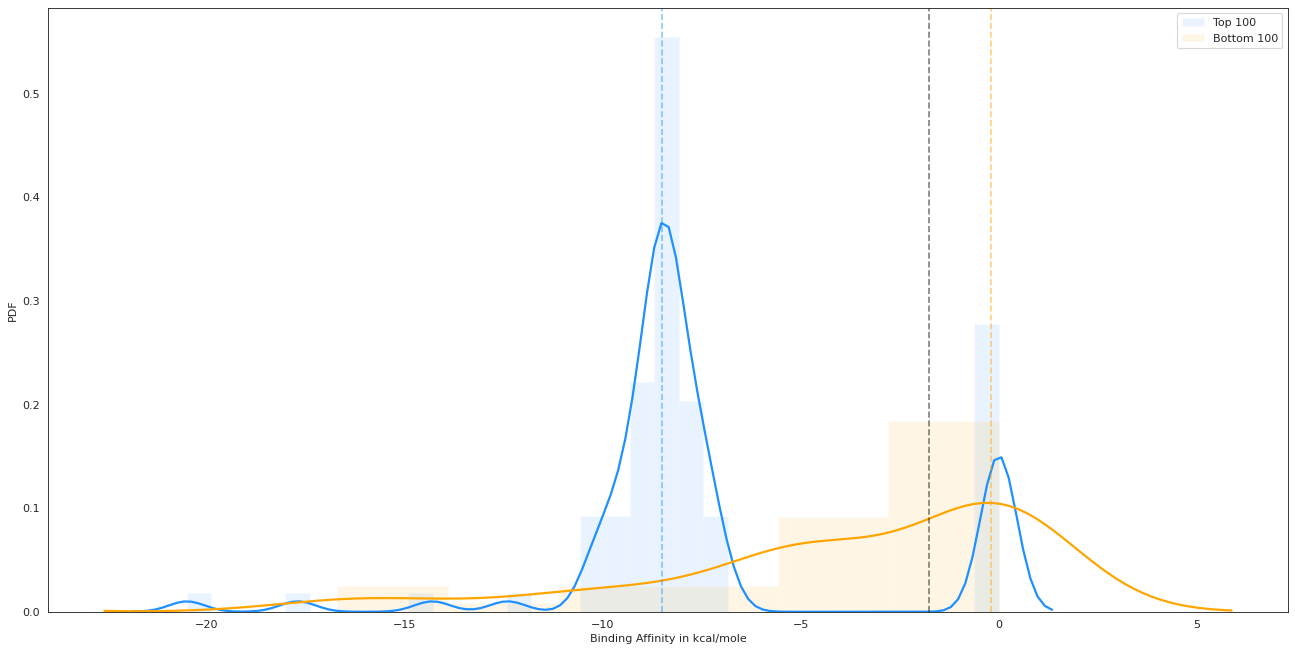

In [142]:
sns.set_style("white")

# Plot
kwargs = dict(hist_kws={'alpha':.1}, kde_kws={'linewidth':2})

plt.figure(figsize=(20,10), dpi= 80)
sns.distplot(top_predictions['binding_affinity'].tolist(), color="dodgerblue", label="Top 100", **kwargs)
sns.distplot(bottom_predictions['binding_affinity'].tolist(), color="orange", label="Bottom 100", **kwargs)
plt.xlabel('Binding Affinity in kcal/mole')
plt.ylabel('PDF')
plt.axvline(x=-1.75,color='k', linestyle='--',alpha=0.5)
plt.axvline(x=-8.5,color='dodgerblue', linestyle='--',alpha=0.5)
plt.axvline(x=-0.2,color='orange', linestyle='--',alpha=0.5)
#plt.xlim(50,75)
plt.legend();

In [133]:
np.mean(top_predictions['binding_affinity'].tolist())

-7.389655172413791

In [134]:
np.mean(bottom_predictions['binding_affinity'].tolist())

-3.7813953488372096

In [119]:
top_binding_list = []

for x in top_predictions['binding_affinity'].tolist():
    if x < -1.75:
        top_binding_list.append(x)
        
bottom_binding_list = []

for x in bottom_predictions['binding_affinity'].tolist():
    if x < -1.75:
        bottom_binding_list.append(x)

In [120]:
len(top_binding_list) / len(top_predictions['binding_affinity'].tolist())

0.8275862068965517

In [121]:
len(bottom_binding_list) / len(bottom_predictions['binding_affinity'].tolist())

0.5116279069767442

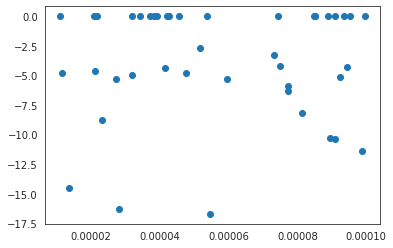

In [123]:
plt.scatter(bottom_predictions['Averaged Predictions'].tolist(),bottom_predictions['binding_affinity'].tolist())

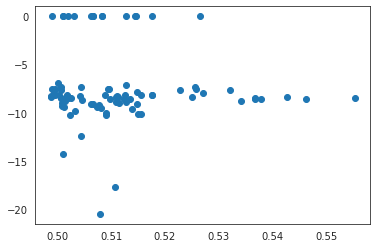

In [115]:
plt.scatter(top_predictions['Averaged Predictions'].tolist(),top_predictions['binding_affinity'].tolist())

In [128]:
set(top_predictions['InChiKey'].tolist()).intersection(set(top_24_inchikeys))

{'WVTKBKWTSCPRNU-KYJUHHDHSA-N'}

In [129]:
top_predictions[top_predictions['InChiKey'] == 'WVTKBKWTSCPRNU-KYJUHHDHSA-N']

,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity
57742,WVTKBKWTSCPRNU-KYJUHHDHSA-N,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.511006,1,-8.3


#### NDM Compounds

In [143]:
all_nodes = pd.read_csv('/data/sars-busters-consolidated/nw_files/WholeNetworkNodesTable.csv')

In [147]:
len(all_nodes[all_nodes['IsNDM'] == True]['Label'].tolist())

485

In [148]:
set(top_predictions['InChiKey'].tolist()).intersection(set(all_nodes[all_nodes['IsNDM'] == True]['Label'].tolist()))

{'LXMSZDCAJNLERA-ZHYRCANASA-N',
 'MIJYXULNPSFWEK-GTOFXWBISA-N',
 'YKOPWPOFWMYZJZ-PRIAQAIDSA-N'}

In [149]:
top_predictions[top_predictions['InChiKey'] == 'LXMSZDCAJNLERA-ZHYRCANASA-N']

,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity
52429,LXMSZDCAJNLERA-ZHYRCANASA-N,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.511460,1,-9.0
52419,LXMSZDCAJNLERA-ZHYRCANASA-N,MQKIMHISVLLSPVLWGLIFGVSSNSIQIGGLFPRGADQEYSAFRV...,GRIA2,0.508983,1,-10.0


In [150]:
top_predictions[top_predictions['InChiKey'] == 'MIJYXULNPSFWEK-GTOFXWBISA-N']

,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity
127372,MIJYXULNPSFWEK-GTOFXWBISA-N,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.504184,1,-8.3


In [151]:
top_predictions[top_predictions['InChiKey'] == 'YKOPWPOFWMYZJZ-PRIAQAIDSA-N']

,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity
267523,YKOPWPOFWMYZJZ-PRIAQAIDSA-N,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.501786,1,-8.3
